In [9]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 10.5 MB/s eta 0:00:00a 0:00:01


## Imports

In [93]:
import os
import copy
import torch
import shutil
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc


## Criando estrutura de diretórios para treino/teste

In [ ]:
data_dir = '../data'

# Define paths for good and bad images
good_dir = os.path.join(data_dir, 'good')
bad_dir = os.path.join(data_dir, 'bad')

# We'll create train and validation subdirectories for the split
base_dir = '../data_for_training'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Ensure these directories are clean before populating
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.makedirs(train_dir)
os.makedirs(validation_dir)
os.makedirs(os.path.join(train_dir, 'good'))    # Combine and create labels
os.makedirs(os.path.join(train_dir, 'bad'))
os.makedirs(os.path.join(validation_dir, 'good'))
os.makedirs(os.path.join(validation_dir, 'bad'))

In [89]:

# Get list of images for good and bad categories
good_images = [os.path.join(good_dir, img) for img in os.listdir(good_dir)]
bad_images = [os.path.join(bad_dir, img) for img in os.listdir(bad_dir)]

# Combine and create labels
all_image_paths = good_images + bad_images
all_labels = ['good'] * len(good_images) + ['bad'] * len(bad_images)

## Perform train-test split

In [ ]:

# Stratify ensures an even distribution of classes in both sets
X_train, X_val, y_train, y_val = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

In [91]:

# Function to copy files to their respective train/validation directories
def copy_files(file_paths, labels, target_base_dir):
    for i, file_path in enumerate(file_paths):
        label = labels[i]
        target_class_dir = os.path.join(target_base_dir, label)
        shutil.copy(file_path, target_class_dir)

In [92]:

copy_files(X_train, y_train, train_dir)
copy_files(X_val, y_val, validation_dir)

In [20]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [21]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32
EPOCHS = 100

In [22]:

# Data transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [23]:

# Paths to training and validation directories
train_dir = '../data_for_training/train'
val_dir = '../data_for_training/validation'


In [24]:

# Datasets and dataloaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [25]:

# CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [26]:

model = SimpleCNN().to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [27]:

# Training loop with early stopping
num_epochs = 50
patience = 3
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().to(device).unsqueeze(1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Check early stopping condition
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

# Load best model
model.load_state_dict(best_model_wts)

# Save model
torch.save(model.state_dict(), "cnn_model.pth")


Epoch 1/50, Train Loss: 0.7417, Val Loss: 0.5644
Epoch 2/50, Train Loss: 0.5754, Val Loss: 0.4781
Epoch 3/50, Train Loss: 0.5250, Val Loss: 0.4645
Epoch 4/50, Train Loss: 0.4579, Val Loss: 0.5434
Epoch 5/50, Train Loss: 0.4321, Val Loss: 0.4010
Epoch 6/50, Train Loss: 0.3497, Val Loss: 0.3745
Epoch 7/50, Train Loss: 0.2925, Val Loss: 0.2410
Epoch 8/50, Train Loss: 0.2166, Val Loss: 0.2537
Epoch 9/50, Train Loss: 0.1865, Val Loss: 0.2971
Epoch 10/50, Train Loss: 0.0989, Val Loss: 0.2711
Early stopping triggered.


In [28]:
# Evaluation
model.eval()
y_true, y_pred, y_scores = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        scores = outputs.cpu().numpy()
        preds = (outputs > 0.5).int().cpu().numpy()
        y_scores.extend(scores)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# Metrics
y_true = [int(label) for label in y_true]
y_pred = [int(p[0]) for p in y_pred]
y_scores = [float(s[0]) for s in y_scores]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))


Accuracy: 0.9125
Precision: 0.8837209302325582
Recall: 0.95
F1 Score: 0.9156626506024096


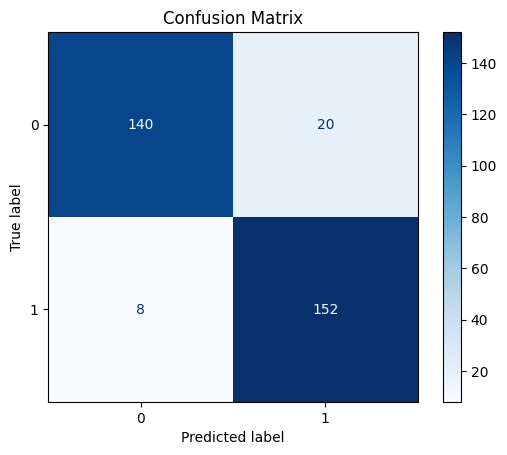

In [29]:

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


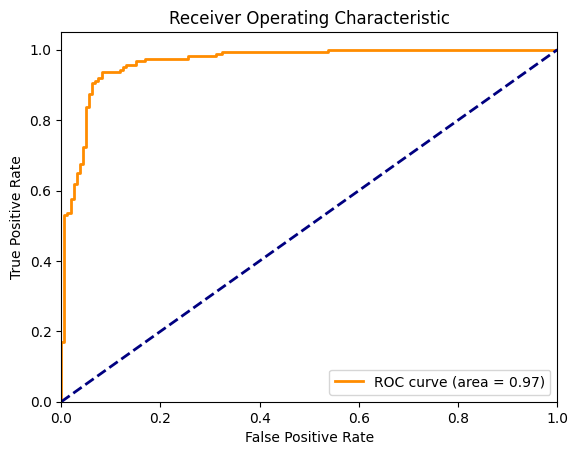

In [30]:

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


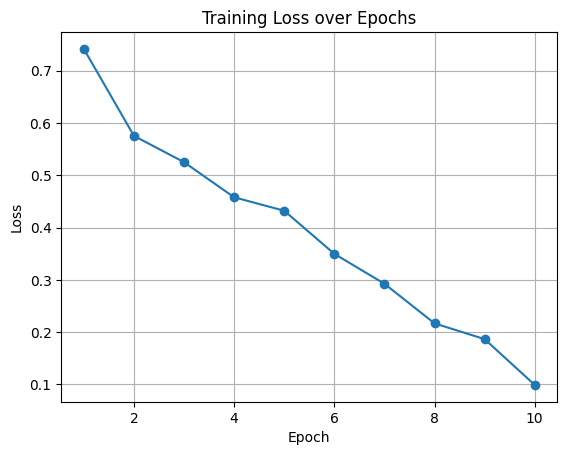

In [32]:

# Plot training loss
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


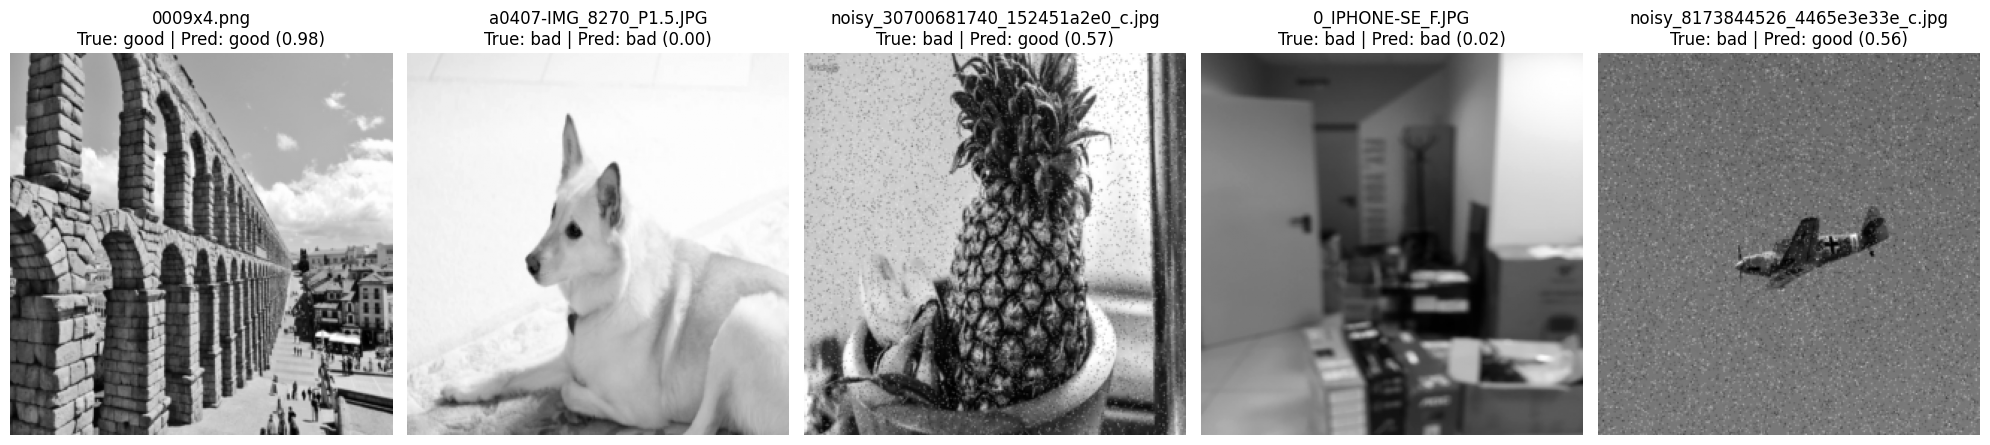

In [108]:
# Predict and display 5 random samples from validation set
model.eval()
class_names = val_dataset.classes
fig, axs = plt.subplots(1, 5, figsize=(20, 10))
samples = random.sample(range(len(val_dataset)), 5)

for i, idx in enumerate(samples):
    path, _ = val_dataset.samples[idx]
    image, label = val_dataset[idx]
    image_input = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_input)
        pred = int((output > 0.5).item())
        prob = float(output.item())

    img_np = image.squeeze().cpu().numpy()
    filename = os.path.basename(path)
    axs[i].imshow(img_np, cmap='gray')
    axs[i].set_title(f"{filename}\nTrue: {class_names[label]} | Pred: {class_names[pred]} ({prob:.2f})")
    axs[i].axis('off')

plt.tight_layout()
plt.show()